In [1]:
from pytorch3d.datasets import ShapeNetCore
import os
from open3d import open3d as o3d
import numpy as np
import trimesh
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
class ShapeNetVoxelizer:
    def __init__(self, resolution=32):
        self.resolution = resolution
        self.voxel_size = 1.0 / self.resolution

    def load_mesh(self, obj_path):
        """
        Load a mesh from an OBJ file, ensuring it is triangulated.
        Handles both single meshes and scenes with multiple meshes.
        """
        loaded = trimesh.load(obj_path)

        # If the loaded object is a Scene, process all geometries
        if isinstance(loaded, trimesh.Scene):
            # Attempt to convert the scene to a single mesh
            # This combines all geometries in the scene into one mesh
            mesh = trimesh.util.concatenate(tuple(loaded.geometry.values()))
        else:
            # If it's already a Trimesh object, use it directly
            mesh = loaded

        # Ensure the mesh is triangulated
        #if not mesh.is_empty and hasattr(mesh, 'faces'):
            #mesh = mesh.split()[0]  # Split into individual components and take the first, if necessary
            #mesh = mesh.triangulate()

        # Convert to Open3D mesh
        if not mesh.is_empty:
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            o3d_mesh = o3d.geometry.TriangleMesh()
            o3d_mesh.vertices = o3d.utility.Vector3dVector(vertices)
            o3d_mesh.triangles = o3d.utility.Vector3iVector(faces)
            o3d_mesh.compute_vertex_normals()
        else:
            o3d_mesh = o3d.geometry.TriangleMesh()

        return o3d_mesh

    
    def normalize_mesh(self, mesh):
        """
        Normalize the mesh to fit within a unit cube centered at the origin.
        """
        aabb = mesh.get_axis_aligned_bounding_box()
        max_dim = max(aabb.get_extent())
        scale_factor = 1.0 / max_dim
        mesh.scale(scale_factor, center=aabb.get_center())
        mesh.translate(-mesh.get_center())
        #print(f"Vertices: {len(mesh.vertices)}, Faces: {len(mesh.triangles)}")
        return mesh

    def mesh_to_voxel_grid(self, mesh):
        """
        Convert a mesh to a voxel grid of the specified resolution.
        """
        voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(
            mesh,
            voxel_size=self.voxel_size
        )
        return voxel_grid

    def voxel_grid_to_array(self, voxel_grid):
        """
        Convert a voxel grid to a numpy array.
        """
        try:
            # Initialize an empty array for the voxel grid
            voxel_array = np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.uint8)

            # Assuming voxel_grid is correctly populated and aligned with the mesh
            for voxel in voxel_grid.get_voxels():
                # Calculate voxel indices based on the voxel grid's resolution and bounds
                index = voxel.grid_index
                if all(0 <= idx < self.resolution for idx in index):
                    voxel_array[index[0], index[1], index[2]] = 1

            return voxel_array
        except Exception as e:
            print(f"Error converting voxel grid to array: {e}")
            return np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.uint8)


    def process_obj_file(self, obj_path):
        """
        Full processing pipeline for converting an OBJ file to a voxel grid array.
        """
        mesh = self.load_mesh(obj_path)
        normalized_mesh = self.normalize_mesh(mesh)
        voxel_grid = self.mesh_to_voxel_grid(normalized_mesh)
        voxel_array = self.voxel_grid_to_array(voxel_grid)
        return voxel_array


In [6]:
# Initialize ShapeNetCore dataset
SHAPENET_PATH = "D:/ShapeNet"
shapenet_dataset = ShapeNetCore(SHAPENET_PATH, version=2)

c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 207e69af994efa9330714334794526d4 under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 2307b51ca7e4a03d30714334794526d4 under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 302612708e86efea62d2c237bfbc22ca under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 3c33f9f8edc558ce77aa0b62eed1492 under synset directory 02958343.
  warnings.warn(ms

In [7]:
print(len(shapenet_dataset))

52472


In [8]:
# Initialize the voxelizer
voxelizer = ShapeNetVoxelizer(resolution=32)

model = shapenet_dataset[55]
obj_path = os.path.join(SHAPENET_PATH, model['synset_id'], model['model_id'], shapenet_dataset.model_dir)

voxel_array = voxelizer.process_obj_file(obj_path)

# Save the voxel array to a file
np.save("voxel_array.npy", voxel_array)
print(f"Voxel array shape: {voxel_array.shape}")

# Print synset ID and model ID
print(f"Synset ID: {model['synset_id']}, Model ID: {model['model_id']}")

c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\io\mtl_io.py:102: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


Voxel array shape: (32, 32, 32)
Synset ID: 02924116, Model ID: 2060f00f9a4f3d7437277701a400254a


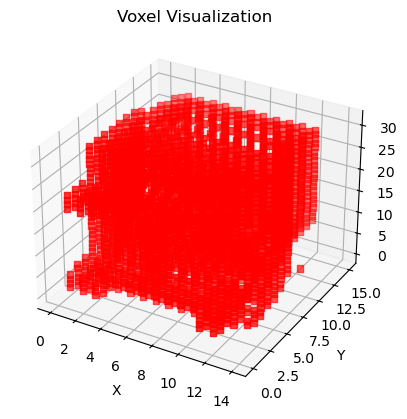

In [9]:
# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the indices of the filled voxels
filled_indices = np.argwhere(voxel_array == 1)

# Plot the filled voxels as a 3D scatter plot
ax.scatter(filled_indices[:, 0], filled_indices[:, 1], filled_indices[:, 2], c='red', marker='s')

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Voxel Visualization')

plt.show()

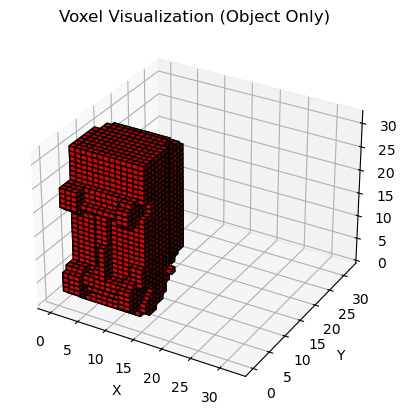

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

# Plot the filled voxels
ax.voxels(voxel_array, facecolors='red', edgecolor="black")

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Voxel Visualization (Object Only)')

plt.show()

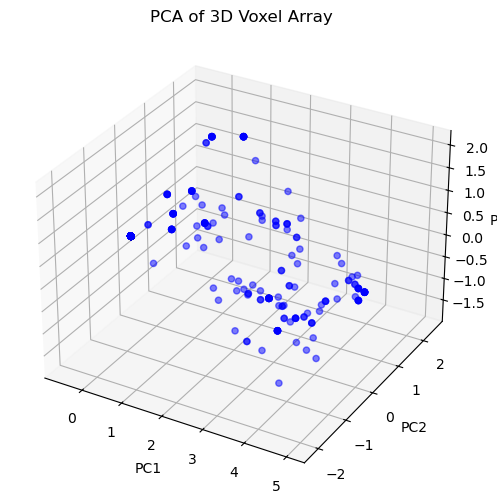

In [25]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate a sample 3D voxel array (replace this with your own data)
# Assume 'voxels' is a 3D NumPy array with shape (depth, height, width)
# Each voxel contains some intensity value (e.g., grayscale value)

# Perform PCA
voxels_flat = voxel_array.reshape(-1, voxel_array.shape[-1])  # Flatten to 2D
pca = PCA(n_components=3)
pca.fit(voxels_flat)
voxels_transformed = pca.transform(voxels_flat)

# Visualize the first three principal components
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot of transformed data
ax.scatter(
    voxels_transformed[:, 0],
    voxels_transformed[:, 1],
    voxels_transformed[:, 2],
    c="b",
    marker="o",
    alpha=0.5,
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA of 3D Voxel Array")

plt.show()

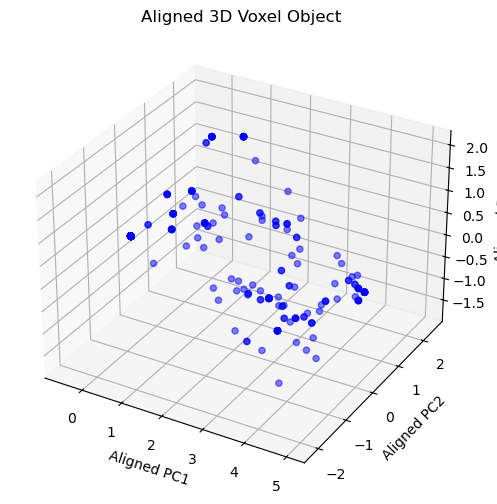

In [30]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have loaded your 3D voxel data into 'voxel_array'
# and it's in the format of (N, 3), where N is the number of voxels,
# and the columns represent the x, y, z coordinates of each voxel.

# Reshape 'voxel_array' to a 2D array of shape (N*M, 3)
voxel_array_2d = voxel_array.reshape(-1, voxel_array.shape[-1])

# Now 'voxel_array_2d' is a 2D array where each row is a voxel and the columns are the x, y, z coordinates

# Perform PCA
pca = PCA(n_components=3)
pca.fit(voxel_array_2d)
voxels_transformed = pca.transform(voxel_array_2d)

# Visualization of the aligned object
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot of aligned data
ax.scatter(
    voxels_transformed[:, 0],
    voxels_transformed[:, 1],
    voxels_transformed[:, 2],
    c="b",  # Color
    marker="o",  # Marker style
    alpha=0.5,  # Transparency
)

# Setting the labels for each axis
ax.set_xlabel("Aligned PC1")
ax.set_ylabel("Aligned PC2")
ax.set_zlabel("Aligned PC3")
ax.set_title("Aligned 3D Voxel Object")

# Display the plot
plt.show()


In [31]:
import numpy as np
from sklearn.decomposition import PCA

# Assume voxel_array is your input 3D points data in the format (N, 3)

# Step 1: Perform PCA
pca = PCA(n_components=3)
pca.fit(voxel_array)
voxels_transformed = pca.transform(voxel_array)

# Step 2: Align the object along PC1 - already done by PCA transformation

# Step 3: Map the transformed coordinates to a 32x32x32 grid
# Normalize coordinates to 0-31 range for each axis
min_vals = voxels_transformed.min(axis=0)
max_vals = voxels_transformed.max(axis=0)
scaled_voxels = (voxels_transformed - min_vals) / (max_vals - min_vals) * 31  # Scale points to fit in the 0-31 range

# Initialize an empty voxel grid
grid_resolution = (32, 32, 32)
voxel_grid = np.zeros(grid_resolution, dtype=bool)

# Fill in the grid - mark the cell as filled if there's at least one point mapped to it
for voxel in scaled_voxels.astype(int):
    voxel_grid[tuple(voxel)] = True

# Step 4: Visualize the voxel grid
# For simplicity, let's plot points where the voxel grid is True
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x, y, z = np.indices(grid_resolution)
x, y, z = x[voxel_grid], y[voxel_grid], z[voxel_grid]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Object Aligned Along PC1 in a 32x32x32 Grid')

plt.show()

ValueError: Found array with dim 3. PCA expected <= 2.

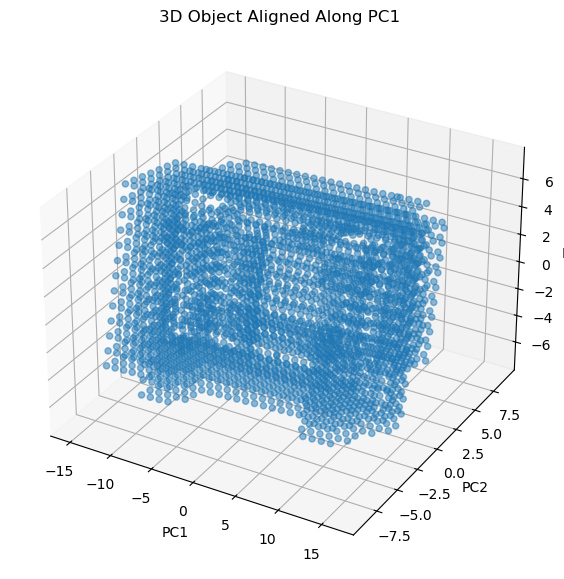

In [32]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example to convert 3D voxel data into a set of coordinates
# Let's assume voxel_array is a 3D boolean array where True indicates the presence of a voxel
# First, extract the x, y, z coordinates of each voxel
x, y, z = np.where(voxel_array)  # This is assuming voxel_array is a 3D boolean array
voxel_coords = np.vstack((x, y, z)).T  # Combine the coordinates into a (N, 3) array

# Perform PCA on the voxel coordinates
pca = PCA(n_components=3)
pca.fit(voxel_coords)
voxels_transformed = pca.transform(voxel_coords)

# Mapping the transformed coordinates to a 32x32x32 grid
# The approach for scaling and populating the grid would remain the same as previously discussed

# For visualization purposes, here is a simple scatter plot of the transformed data
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(voxels_transformed[:, 0], voxels_transformed[:, 1], voxels_transformed[:, 2], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Object Aligned Along PC1')

plt.show()

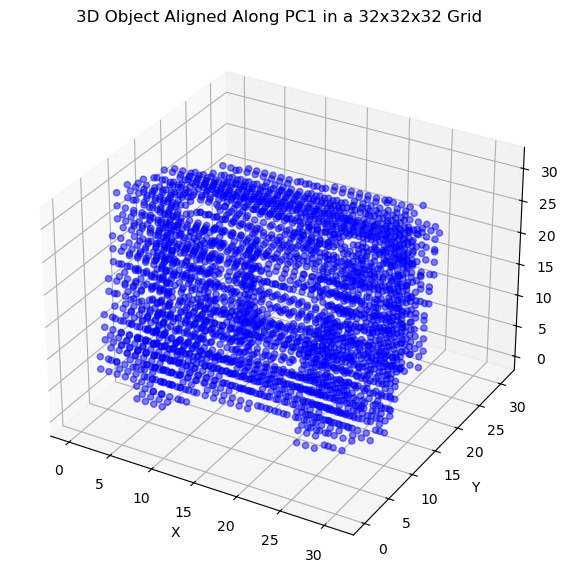

In [33]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume voxel_array is a 3D boolean array with shape (depth, height, width), where True indicates the presence of a voxel

# Extract the x, y, z coordinates of each voxel
x, y, z = np.where(voxel_array)
voxel_coords = np.vstack((x, y, z)).T  # Combine the coordinates into a (N, 3) array

# Perform PCA on the voxel coordinates
pca = PCA(n_components=3)
pca.fit(voxel_coords)
voxels_transformed = pca.transform(voxel_coords)

# Scale the transformed coordinates to fit in a 32x32x32 grid
min_vals = voxels_transformed.min(axis=0)
max_vals = voxels_transformed.max(axis=0)
scaled_voxels = (voxels_transformed - min_vals) / (max_vals - min_vals) * 31

# Initialize a 3D grid
grid_resolution = (32, 32, 32)
voxel_grid = np.zeros(grid_resolution, dtype=bool)

# Populate the grid
for voxel in scaled_voxels.astype(int):
    # Ensure the coordinates are within the grid bounds
    voxel_grid[tuple(voxel)] = True

# Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
x, y, z = np.indices(grid_resolution)

# Only plot the voxels that are True
ax.scatter(x[voxel_grid], y[voxel_grid], z[voxel_grid], alpha=0.5, c='blue')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Object Aligned Along PC1 in a 32x32x32 Grid')

plt.show()

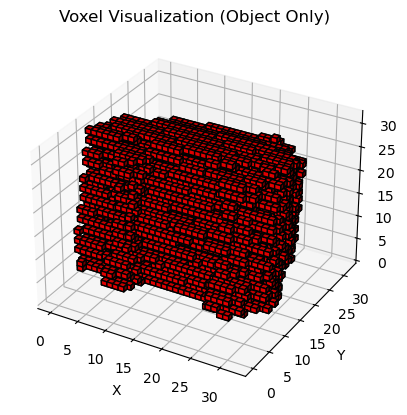

In [34]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume voxel_array is your 3D boolean array where True indicates the presence of a voxel
# Extract x, y, z coordinates where voxel exists
x, y, z = np.where(voxel_array)
voxel_coords = np.vstack((x, y, z)).T

# Perform PCA
pca = PCA(n_components=3)
pca.fit(voxel_coords)
voxels_transformed = pca.transform(voxel_coords)

# Scale the transformed coordinates to fit in the 32x32x32 grid
min_vals = voxels_transformed.min(axis=0)
max_vals = voxels_transformed.max(axis=0)
scaled_voxels = (voxels_transformed - min_vals) / (max_vals - min_vals) * 31

# Initialize an empty 32x32x32 grid
new_voxel_grid = np.zeros((32, 32, 32), dtype=bool)

# Populate the grid - convert scaled coordinates to integers to use as indices
for voxel in np.round(scaled_voxels).astype(int):
    # Use min/max to avoid index out of bounds error
    i, j, k = np.clip(voxel, 0, 31)
    new_voxel_grid[i, j, k] = True

# Visualization using matplotlib's ax.voxels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the filled voxels, facecolors for filled and edgecolor for the edges
ax.voxels(new_voxel_grid, facecolors='red', edgecolor='k')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Voxel Visualization (Object Only)')

plt.show()


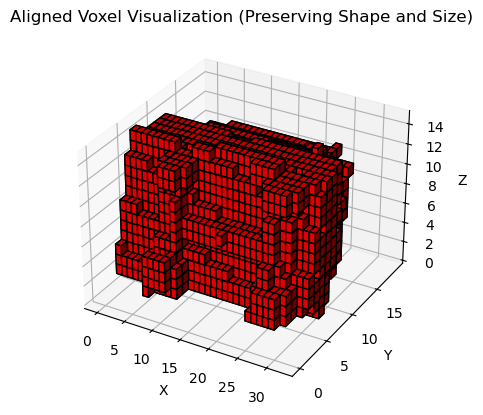

In [35]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract x, y, z coordinates where voxel exists
x, y, z = np.where(voxel_array)
voxel_coords = np.vstack((x, y, z)).T

# Perform PCA
pca = PCA(n_components=3)
voxel_coords_centered = voxel_coords - np.mean(voxel_coords, axis=0) # Centering the data
pca.fit(voxel_coords_centered)
rotation_matrix = pca.components_.T # The rotation matrix aligning data with the principal components

# Apply the rotation to align the object along principal components
aligned_voxels = np.dot(voxel_coords_centered, rotation_matrix)

# Since we're interested in visualizing without altering the original shape/size, no scaling is applied
# Adjust the translation to ensure all coordinates are positive for visualization
min_vals = aligned_voxels.min(axis=0)
aligned_voxels -= min_vals

# Create a voxel grid with adjusted dimensions based on the aligned voxel extents
max_vals = aligned_voxels.max(axis=0).astype(int) + 1
voxel_grid = np.zeros((max_vals[0], max_vals[1], max_vals[2]), dtype=bool)
for voxel in aligned_voxels.astype(int):
    voxel_grid[tuple(voxel)] = True

# Visualization using matplotlib's ax.voxels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the filled voxels
ax.voxels(voxel_grid, facecolors='red', edgecolor='k')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Aligned Voxel Visualization (Preserving Shape and Size)')

plt.show()